<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Re3_Focal_Loss_VGG16_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU**

In [1]:
!nvidia-smi

Tue May 19 08:27:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# **Import Libraries**

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os
from os.path import join

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

Using TensorFlow backend.


# **Clone Data**

In [4]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

Cloning into 'ham10000-with-one-image-folder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10045 (delta 4), reused 7 (delta 2), pack-reused 10036
Receiving objects: 100% (10045/10045), 2.57 GiB | 48.03 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (10022/10022), done.


# **Constant Variables**

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 2e-6 # Learning rate

# **Prepare Data**

In [0]:
data=pd.read_csv('/content/ham10000-with-one-image-folder/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [7]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_full_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


### **Split Data**

In [0]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [0]:
train = pd.concat([X_train,y_train],axis=1)
val = pd.concat([X_val,y_val],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train = encoder.transform(val['dx']) 
val['label'] = name_as_indexes_train

In [0]:
encoder = LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx']) 
test['label'] = name_as_indexes_test

In [0]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx']) 
test['label'] = name_as_indexes_test

### **Data Augmentation**

In [0]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=360,  
                                     zoom_range = 0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')
                                    
test_generator=ImageDataGenerator(rescale = 1./255)
test_generator=ImageDataGenerator(rescale = 1./255)

In [14]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                                shuffle=True,batch_size=32,class_mode="categorical",target_size=(IMG_WIDTH,IMG_HEIGHT))

val_data= test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=True,batch_size=32,class_mode='categorical',target_size=(IMG_WIDTH,IMG_HEIGHT))

test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 6309 validated image filenames belonging to 7 classes.
Found 2704 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames.


# **Focal Loss**

https://github.com/mkocabas/focal-loss-keras






$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [0]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

# **Build Model**

### **Use VGG16 + fine tuning**

In [0]:
def build_model():
  base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  base_model.trainable = True

  for layer in base_model.layers[:-6]:
      layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(dropout_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
  
  model.compile(optimizer=Adam(LR), loss=[focal_loss(alpha=.25, gamma=2)], metrics=['accuracy'])
  return model

In [0]:
model = build_model()

### **Architecture**

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### **Callbacks**

In [0]:
model_path = '/content/vgg16_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_plateau = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.00001)

In [0]:
cb_list = [checkpoint, early_stop, reduce_plateau]

### **Training**

In [34]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=EPOCHS,
                            callbacks=cb_list)

Epoch 1/100
 84/197 [===========>..................] - ETA: 37s - loss: 0.0723 - acc: 0.0212
Epoch 00001: val_loss improved from -inf to 0.07233, saving model to /content/vgg16_model.h5
197/197 [==============================] - 153s 777ms/step - loss: 0.0719 - acc: 0.3119 - val_loss: 0.0723 - val_acc: 0.0212
Epoch 2/100
 84/197 [===========>..................] - ETA: 38s - loss: 0.0586 - acc: 0.5796
Epoch 00002: val_loss did not improve from 0.07233
197/197 [==============================] - 152s 773ms/step - loss: 0.0657 - acc: 0.4184 - val_loss: 0.0586 - val_acc: 0.5796
Epoch 3/100
 84/197 [===========>..................] - ETA: 38s - loss: 0.0551 - acc: 0.5818
Epoch 00003: val_loss did not improve from 0.07233
197/197 [==============================] - 152s 770ms/step - loss: 0.0625 - acc: 0.4572 - val_loss: 0.0551 - val_acc: 0.5818
Epoch 4/100
 84/197 [===========>..................] - ETA: 39s - loss: 0.0530 - acc: 0.5908
Epoch 00004: val_loss did not improve from 0.07233
197/197

In [0]:
model.save_weights('/content/Re3_Focal-Loss_VGG16_weights.h5')

# **Accuracy and Loss Graph**

### **Accuracy**

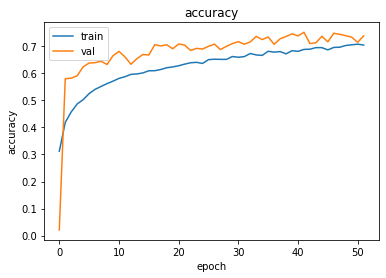

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### **Loss**

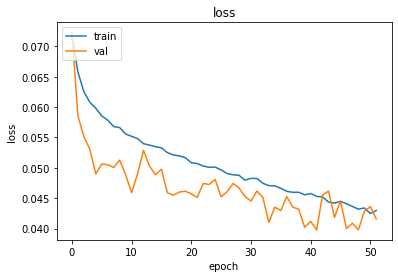

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [37]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

1002/1002 [==============================] - 14s 14ms/step


### **Classification Report**

In [38]:
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(name_as_indexes_test, y_pred))
print('Classification Report')
classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(name_as_indexes_test, y_pred, target_names=classes_names))

Confusion Matrix
[[ 12  14   9   0   2   1   3]
 [  1  35   7   1   1   0   2]
 [  2  10  72   4   7  25   5]
 [  0   6   6   1   0   2   0]
 [  3   3  23   0  52  24   5]
 [  6  29  46   3  31 530   4]
 [  0   1   1   0   0   0  13]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.50      0.29      0.37        41
         bcc       0.36      0.74      0.48        47
         bkl       0.44      0.58      0.50       125
          df       0.11      0.07      0.08        15
         mel       0.56      0.47      0.51       110
          nv       0.91      0.82      0.86       649
        vasc       0.41      0.87      0.55        15

    accuracy                           0.71      1002
   macro avg       0.47      0.55      0.48      1002
weighted avg       0.75      0.71      0.72      1002



### **Confusion Matrix**

Confusion matrix, without normalization
[[ 12  14   9   0   2   1   3]
 [  1  35   7   1   1   0   2]
 [  2  10  72   4   7  25   5]
 [  0   6   6   1   0   2   0]
 [  3   3  23   0  52  24   5]
 [  6  29  46   3  31 530   4]
 [  0   1   1   0   0   0  13]]


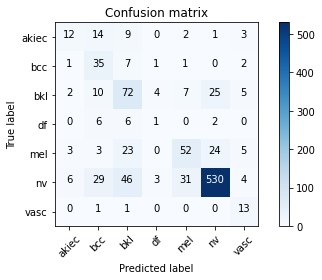

In [39]:
cm = (confusion_matrix(name_as_indexes_test, y_pred))

plot_confusion_matrix(cm, classes_names)

### **Sensitivity & Specificity**

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [41]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.4615
specificity: 0.9722


# **Grad-CAM**

In [0]:
last_conv2d = 'block5_conv2'

### **AKIEC**

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.475
	vasc           	(6)	with probability 0.294
	bkl            	(2)	with probability 0.119
	df             	(3)	with probability 0.042
	akiec          	(0)	with probability 0.036
Explanation for 'mel'


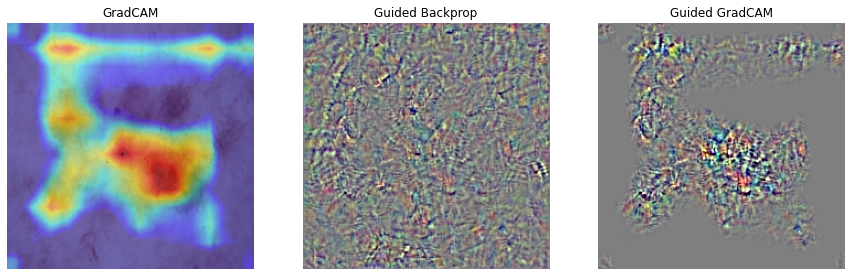

In [78]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

### **BCC**

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	mel            	(4)	with probability 0.288
	bkl            	(2)	with probability 0.181
	vasc           	(6)	with probability 0.169
	bcc            	(1)	with probability 0.157
	akiec          	(0)	with probability 0.107
Explanation for 'mel'


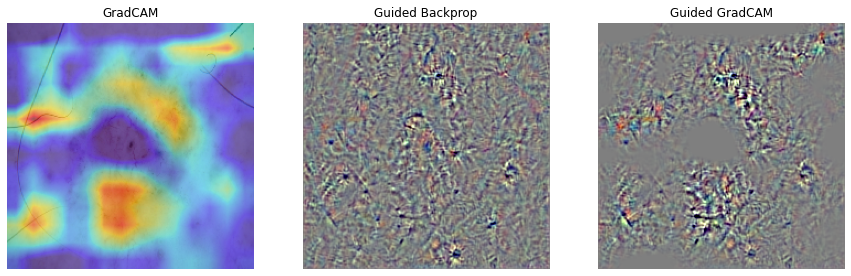

In [80]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

### **BKL**

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.348
	vasc           	(6)	with probability 0.304
	bkl            	(2)	with probability 0.158
	df             	(3)	with probability 0.114
	akiec          	(0)	with probability 0.049
Explanation for 'mel'


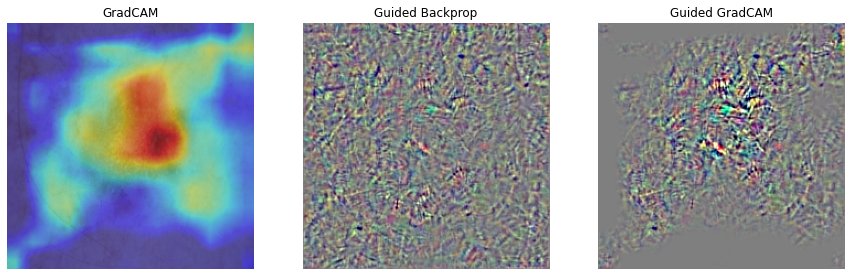

In [82]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

### **DF**

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.383
	nv             	(5)	with probability 0.200
	vasc           	(6)	with probability 0.124
	df             	(3)	with probability 0.083
	akiec          	(0)	with probability 0.076
Explanation for 'mel'


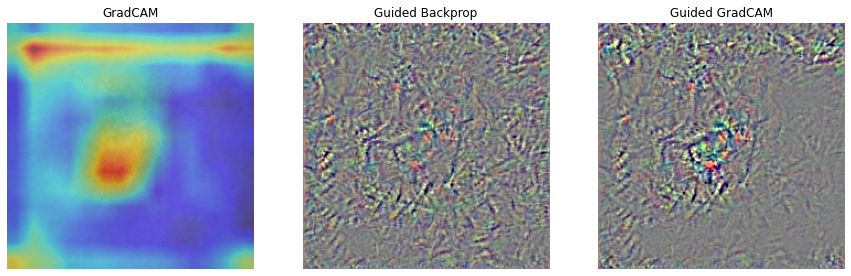

In [84]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

### **MEL**

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.572
	vasc           	(6)	with probability 0.132
	df             	(3)	with probability 0.090
	bkl            	(2)	with probability 0.076
	akiec          	(0)	with probability 0.063
Explanation for 'mel'


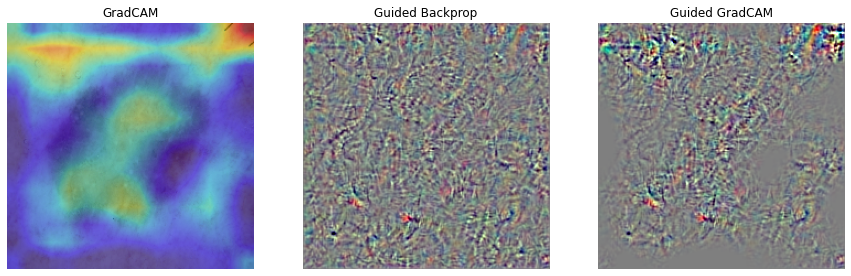

In [86]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

### **NV**

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	mel            	(4)	with probability 0.367
	nv             	(5)	with probability 0.141
	vasc           	(6)	with probability 0.132
	df             	(3)	with probability 0.113
	bkl            	(2)	with probability 0.083
Explanation for 'mel'


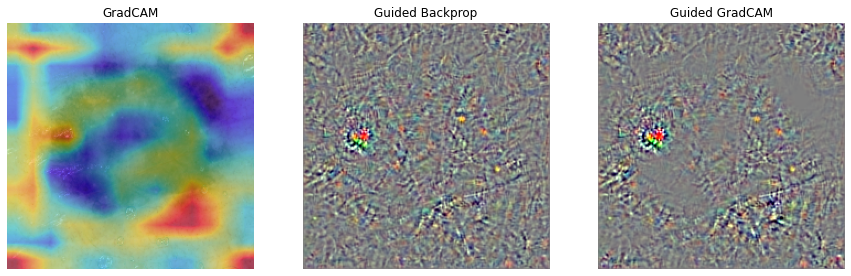

In [88]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

### **VASC**

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	vasc           	(6)	with probability 0.817
	df             	(3)	with probability 0.068
	bkl            	(2)	with probability 0.048
	mel            	(4)	with probability 0.033
	akiec          	(0)	with probability 0.021
Explanation for 'vasc'


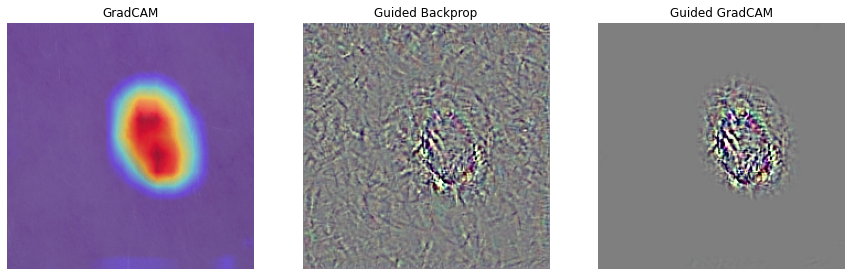

In [90]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# **Download Model**

In [0]:
from google.colab import files

In [94]:
files.download('/content/Re3_Focal-Loss_VGG16_model.h5')


----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 37284, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

MessageError: ignored

In [0]:
files.download('/content/Re3_Focal-Loss_VGG16_weights.h5')